## Library

In [2]:
# !pip install --upgrade
# !pip install numpy scikit-learn pandas yfinance tensorflow matplotlib
# !pip install tensorflow==2.12.0

In [2]:
# Data Preprocessing and Preparation
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


# Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import time

## Data preparation

In [3]:
df = yf.download('KBANK.BK', start="2019-07-01", end="2024-06-30")
df.index = pd.to_datetime(df.index)
df.columns = df.columns.droplevel(1)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-07-01 00:00:00+00:00,157.268051,188.5,191.0,188.5,189.5,6817000
2019-07-02 00:00:00+00:00,157.268051,188.5,189.5,188.0,188.5,3797000
2019-07-03 00:00:00+00:00,157.685165,189.0,189.5,188.0,188.5,3524300
2019-07-04 00:00:00+00:00,156.016571,187.0,190.0,187.0,189.0,7623900
2019-07-05 00:00:00+00:00,156.433731,187.5,188.0,187.0,187.0,2385300


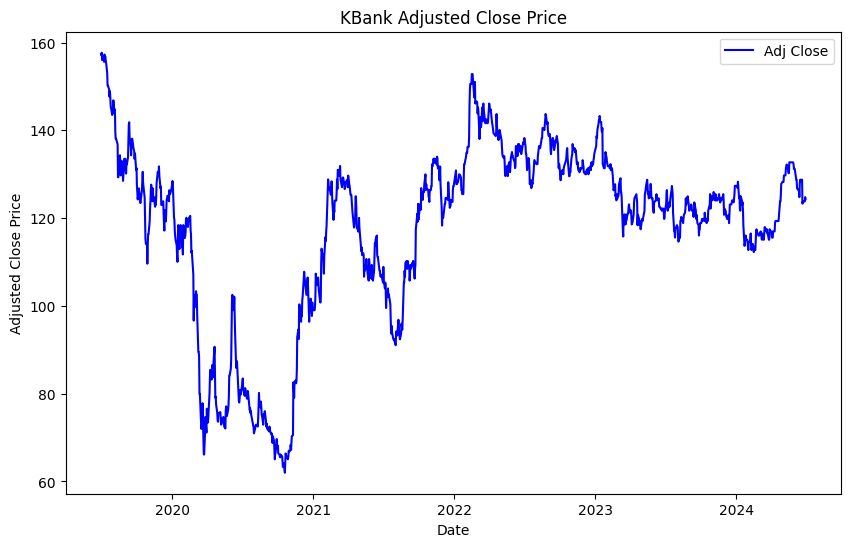

In [4]:
import matplotlib.pyplot as plt

# สมมติว่าคุณมี DataFrame ที่ชื่อว่า dataset ที่มีคอลัมน์ 'Adj Close' และ index เป็น datetime
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='blue')

# ตั้งชื่อกราฟ
plt.title('KBank Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

# แสดง legend และ plot
plt.legend()
plt.show()


In [5]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
df = df.drop('Close',axis=1)
dataset = df
values = dataset.values
values = values.astype('float32')


# ทำ scaling ข้อมูลด้วยวิธี min-max normalized scaling เปลี่ยน scale ข้อมูลแต่ละ column และเก็บค่า mean และ sd แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())


# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 15, 8,feat_name=df.columns)
reframed.drop(['High(t+1)','High(t+2)','High(t+3)','High(t+4)','High(t+5)','High(t+6)','High(t+7)','Low(t+1)','Low(t+2)','Low(t+3)','Low(t+4)','Low(t+5)','Low(t+6)','Low(t+7)',\
               'Open(t+1)','Open(t+2)','Open(t+3)','Open(t+4)','Open(t+5)','Open(t+6)','Open(t+7)','Volume(t+1)','Volume(t+2)','Volume(t+3)','Volume(t+4)','Volume(t+5)',\
               'Volume(t+6)','Volume(t+7)'],axis=1,inplace=True)

In [6]:
reframed.head()

,Adj Close(t-15),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-14),High(t-14),Low(t-14),Open(t-14),Volume(t-14),...,Low(t),Open(t),Volume(t),Adj Close(t+1),Adj Close(t+2),Adj Close(t+3),Adj Close(t+4),Adj Close(t+5),Adj Close(t+6),Adj Close(t+7)
15,0.995641,1.000000,1.000000,1.000000,0.039494,0.995641,0.987288,0.995781,0.991507,0.021998,...,0.902954,0.906582,0.071548,0.908450,0.895372,0.873575,0.851777,0.856136,0.860496,0.886653
16,0.995641,0.987288,0.995781,0.991507,0.021998,1.000000,0.987288,0.995781,0.991507,0.020418,...,0.907173,0.902335,0.026399,0.895372,0.873575,0.851777,0.856136,0.860496,0.886653,0.856136
17,1.000000,0.987288,0.995781,0.991507,0.020418,0.982562,0.991525,0.987342,0.995754,0.044169,...,0.902954,0.906582,0.026877,0.873575,0.851777,0.856136,0.860496,0.886653,0.856136,0.864856
18,0.982562,0.991525,0.987342,0.995754,0.044169,0.986922,0.974576,0.987342,0.978769,0.013819,...,0.877637,0.893843,0.065149,0.851777,0.856136,0.860496,0.886653,0.856136,0.864856,0.812541
19,0.986922,0.974576,0.987342,0.978769,0.013819,0.982562,0.974576,0.978903,0.978769,0.025213,...,0.860759,0.876858,0.042190,0.856136,0.860496,0.886653,0.856136,0.864856,0.812541,0.795103


In [7]:
values = reframed.values

# Define the number of days for each set
# ทำ train, val, test split
values = reframed.values
n_train_percent = 0.7
n_val_percent = 0.15
train_split = int(values.shape[0] * n_train_percent)
val_split = int(values.shape[0] * (n_train_percent + n_val_percent))

train = values[:train_split, :]
val = values[train_split:val_split, :]
test = values[val_split:, :]

# เก็บค่า datetime ของ train, val, test
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:train_split]
date_val = date_reframed[train_split:val_split]
date_test = date_reframed[val_split:]

# split feature และ target
train_X, train_y = train[:, :-7], train[:, -7:]
val_X, val_y = val[:, :-7], val[:, -7:]
test_X, test_y = test[:, :-7], test[:, -7:]

# reshape input ให้เป็น 3D (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [8]:
# X (samples, timesteps, features)
# Y (samples , target)
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(832, 1, 80)
(832, 7)
(178, 1, 80)
(178, 7)
(179, 1, 80)
(179, 7)


## Create Model & Evaluate (ยังไม่ Hyperparameter tuning)


In [139]:
model = Sequential()

# LSTM 2 layer with ReLU activation
model.add(LSTM(units=70,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(LSTM(units=70,activation='relu'))
model.add(Dropout(0.1))

# Output layer for 1 targets
model.add(Dense(1))

# Compile the model with  learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 70)             42280     
                                                                 
 dropout_40 (Dropout)        (None, 1, 70)             0         
                                                                 
 lstm_17 (LSTM)              (None, 70)                39480     
                                                                 
 dropout_41 (Dropout)        (None, 70)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 71        
                                                                 
Total params: 81,831
Trainable params: 81,831
Non-trainable params: 0
_________________________________________________________________


In [140]:
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(val_X, val_y),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])



Epoch 1/100
13/13 [==============================] - 3s 32ms/step - loss: 0.3866 - root_mean_squared_error: 0.5230 - val_loss: 0.2858 - val_root_mean_squared_error: 0.4304
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1530 - root_mean_squared_error: 0.2465 - val_loss: 0.0901 - val_root_mean_squared_error: 0.0856
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1001 - root_mean_squared_error: 0.1584 - val_loss: 0.0964 - val_root_mean_squared_error: 0.1714
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0809 - root_mean_squared_error: 0.1385 - val_loss: 0.0660 - val_root_mean_squared_error: 0.1013
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0672 - root_mean_squared_error: 0.1257 - val_loss: 0.0558 - val_root_mean_squared_error: 0.0949
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0578 - root_mean_squared_error: 0.1195 - val_loss: 0.0524 - val_root_

In [141]:
# คำนวณ predicted values
yhat_train = model.predict(train_X)
yhat_val = model.predict(val_X)
yhat_test = model.predict(test_X)


6/6 [==============================] - 0s 2ms/step


In [142]:
# คำนวณ residuals
resid_train = train_y - yhat_train
resid_val = val_y - yhat_val
resid_test = test_y - yhat_test

In [69]:
# # Reshape residuals for GRU input (samples, timesteps, features)
# resid_train = resid_train.reshape((resid_train.shape[0], 1, resid_train.shape[1]))
# resid_val = resid_val.reshape((resid_val.shape[0], 1, resid_val.shape[1]))
# resid_test = resid_test.reshape((resid_test.shape[0], 1, resid_test.shape[1]))

In [143]:
# เตรียมข้อมูล train สำหรับ residual GRU
train_X_resid = train_X.copy()
train_y_resid = resid_train.copy()
val_X_resid = val_X.copy()
val_y_resid = resid_val.copy()
test_X_resid = test_X.copy()
test_y_resid = resid_test.copy()

In [144]:
print(train_X_resid.shape)
print(train_y_resid.shape)
print(val_X_resid.shape)
print(val_y_resid.shape)
print(test_X_resid.shape)
print(test_y_resid.shape)

(832, 1, 80)
(832, 1)
(178, 1, 80)
(178, 1)
(179, 1, 80)
(179, 1)


In [145]:
# GRU model for predicting residuals
res_model = Sequential()
res_model.add(GRU(units=50, activation='relu', input_shape=(train_X_resid.shape[1], train_X_resid.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
res_model.add(Dropout(0.1))
res_model.add(GRU(units=50, activation='relu'))
res_model.add(Dropout(0.1))
res_model.add(Dense(1))

# Compile the GRU model
optimizer = Adam(learning_rate=0.001)
res_model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [146]:
# Train the GRU model
history_gru = res_model.fit(train_X_resid, train_y_resid, epochs=100, batch_size=64, validation_data=(val_X_resid, val_y_resid), 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/100
13/13 [==============================] - 2s 33ms/step - loss: 0.0998 - root_mean_squared_error: 0.0713 - val_loss: 0.0853 - val_root_mean_squared_error: 0.0434
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0794 - root_mean_squared_error: 0.0689 - val_loss: 0.0671 - val_root_mean_squared_error: 0.0441
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0627 - root_mean_squared_error: 0.0687 - val_loss: 0.0522 - val_root_mean_squared_error: 0.0442
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0493 - root_mean_squared_error: 0.0687 - val_loss: 0.0405 - val_root_mean_squared_error: 0.0450
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0387 - root_mean_squared_error: 0.0681 - val_loss: 0.0312 - val_root_mean_squared_error: 0.0440
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0305 - root_mean_squared_error: 0.0682 - val_loss: 0.0242 - val_root_

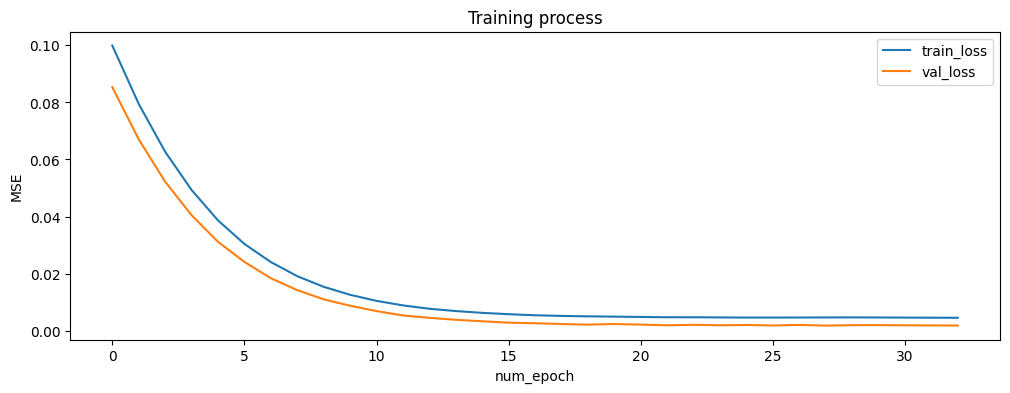

In [147]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history_gru.history['loss'], label='train_loss')
plt.plot(history_gru.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [148]:
results = model.evaluate(test_X, test_y)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 2ms/step - loss: 0.0030 - root_mean_squared_error: 0.0431
Test Loss: 0.003018162213265896
Test RMSE: 0.043124038726091385


In [150]:
# คำนวณ predicted residuals
yhat_train_resid = res_model.predict(train_X_resid)
yhat_val_resid = res_model.predict(val_X_resid)
yhat_test_resid = res_model.predict(test_X_resid)

6/6 [==============================] - 0s 1ms/step


In [151]:
# Final predicted value = LSTM predicted value + GRU predicted residuals
final_yhat_train = yhat_train + yhat_train_resid
final_yhat_val = yhat_val + yhat_val_resid
final_yhat_test = yhat_test + yhat_test_resid


In [152]:
# Reshape ข้อมูล (ถ้าจำเป็น)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Rescale ข้อมูลกลับ (ในกรณีใช้ Min-Max Normalization)
inv_yhat_train = final_yhat_train * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_val = final_yhat_val * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_test = final_yhat_test * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']

inv_y_train = train_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_val = val_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_test = test_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']


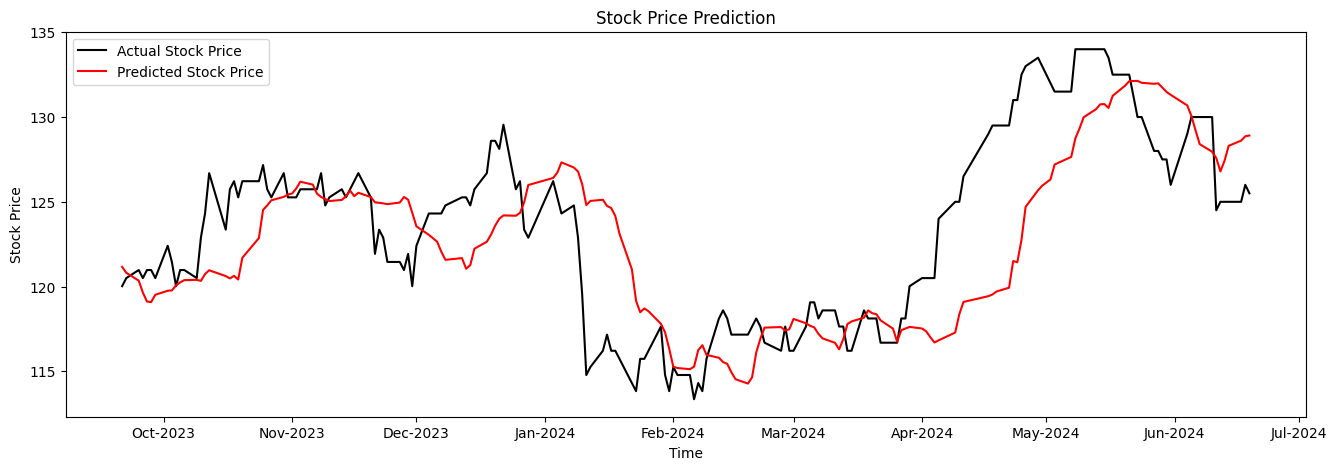

In [153]:
# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(16, 5))
plt.plot(date_test, inv_y_test[:, 0], color='black', label='Actual Stock Price')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='Predicted Stock Price')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 3 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# ตั้งชื่อกราฟ
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

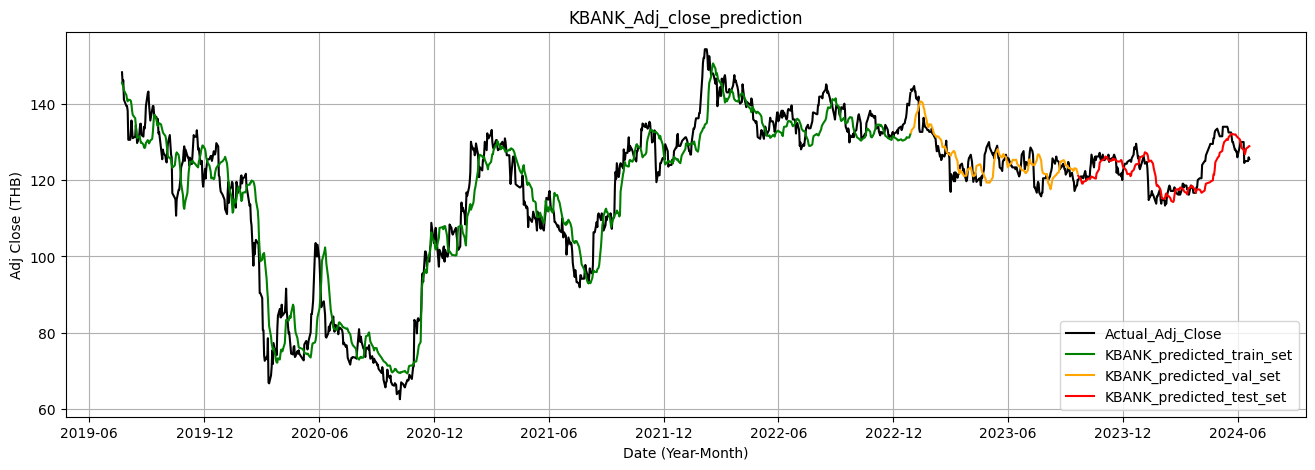

In [154]:
# Visualizing Results
plt.figure(figsize=(16, 5))

# Actual prices
plt.plot(date_train, inv_y_train[:, 0], color='black', label='Actual_Adj_Close')
plt.plot(date_val, inv_y_val[:, 0], color='black')
plt.plot(date_test, inv_y_test[:, 0], color='black')

# Predicted prices
plt.plot(date_train, inv_yhat_train[:, 0], color='green', label='predicted_train_set')
plt.plot(date_val, inv_yhat_val[:, 0], color='orange', label='predicted_val_set')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='predicted_test_set')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 6 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# ตั้งชื่อกราฟ
plt.title('KBANK_Adj_close_prediction')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Adj Close (THB)')
plt.legend()
plt.grid(True)
plt.show()


In [155]:
# คำนวณ MAPE และ RMSE
mape = mean_absolute_percentage_error(inv_y_test, inv_yhat_test)*100
rmse = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))

# แสดงผลลัพธ์
print(f'MAPE: {mape:.4f}%')
print(f'RMSE: {rmse:.4f}')


MAPE: 2.3950%
RMSE: 3.9270


## Hyperparameter Tuning (Predicted Value)

In [9]:
def create_lstm_model(lstm_units_1, beta_1 ,LR,L2):
    model = Sequential()
    model.add(LSTM(lstm_units_1,activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, kernel_regularizer=l2(L2)))
    model.add(Dropout(0.1))
    model.add(Dense(7))
    optimizer = Adam(learning_rate=LR, beta_1=beta_1, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Define the hyperparameters to tune lstm
param_dist_lstm = {
    'lstm_units_1': list(range(1, 101)),
    'LR': np.linspace(0.001, 0.1, 100).tolist(),
    'L2':[0.001,0.005,0.01,0.05,0.1],
    'beta_1':[0.7,0.8,0.9]
}

# Wrap the model into a KerasRegressor
lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=64, verbose=0)

start_time = time.time()

# Define the RandomizedSearchCV object
lstm_random_search = RandomizedSearchCV(estimator=lstm_model, param_distributions=param_dist_lstm,
                                    n_iter=100, scoring='neg_root_mean_squared_error',
                                    cv=3, verbose=1, random_state=42, n_jobs=-1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using RandomizedSearchCV
lstm_random_search_result = lstm_random_search.fit(train_X, train_y, validation_data=(val_X, val_y), callbacks=[early_stopping])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

/tmp/ipykernel_3895566/3692575797.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=64, verbose=0)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024-12-19 13:19:23.384051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:19:23.470998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:19:23.507364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:19:23.580534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:19:23.598301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:19:23.767435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:19:23.767456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:19:23.798886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-

Execution time: 2941.2091443538666 seconds


In [10]:
# Get the best parameters and the best score
lstm_best_params = lstm_random_search_result.best_params_
lstm_best_score = -lstm_random_search_result.best_score_


In [11]:
print("Best Parameters:", lstm_best_params)
print("Best RMSE Score:", lstm_best_score)

Best Parameters: {'lstm_units_1': 12, 'beta_1': 0.9, 'LR': 0.018000000000000002, 'L2': 0.001}
Best RMSE Score: 0.0674671164285783


## Hyperparameter Tuning (Predicted Residual)

In [12]:
lstm_model = create_lstm_model(lstm_units_1=12 ,beta_1=0.9, LR=0.018, L2=0.001)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 12)                4464      
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 91        
                                                                 
Total params: 4,555
Trainable params: 4,555
Non-trainable params: 0
_________________________________________________________________


2024-12-19 13:59:49.534593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 13:59:49.536401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 13:59:49.537649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
history = lstm_model.fit(train_X, train_y, epochs=150, batch_size=64, validation_data=(val_X, val_y),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/150


2024-12-19 13:59:52.606843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 13:59:52.608967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 13:59:52.610808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/13 [=>............................] - ETA: 23s - loss: 0.4022 - root_mean_squared_error: 0.5851

2024-12-19 13:59:54.685647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 13:59:54.687610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 13:59:54.689095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 3s 51ms/step - loss: 0.1271 - root_mean_squared_error: 0.2882 - val_loss: 0.0502 - val_root_mean_squared_error: 0.1378
Epoch 2/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0574 - root_mean_squared_error: 0.1795 - val_loss: 0.0211 - val_root_mean_squared_error: 0.0486
Epoch 3/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0343 - root_mean_squared_error: 0.1406 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0439
Epoch 4/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0238 - root_mean_squared_error: 0.1212 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0640
Epoch 5/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0172 - root_mean_squared_error: 0.1048 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0787
Epoch 6/150
13/13 [==============================] - 0s 7ms/step - loss: 0.0144 - root_mean_squared_error: 0.1001 - val_loss: 0.0105 - val_root_mean_squared

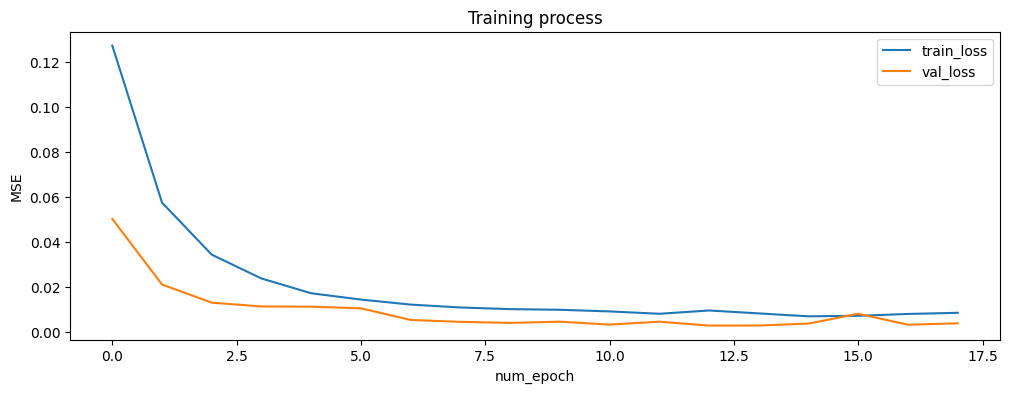

In [14]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [15]:
results = lstm_model.evaluate(test_X, test_y)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 2ms/step - loss: 0.0031 - root_mean_squared_error: 0.0409
Test Loss: 0.0031066685914993286
Test RMSE: 0.040929608047008514


In [16]:
# คำนวณ predicted values
yhat_train = lstm_model.predict(train_X)
yhat_val = lstm_model.predict(val_X)
yhat_test = lstm_model.predict(test_X)


 1/26 [>.............................] - ETA: 19s

2024-12-19 14:00:04.210040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:00:04.212176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:00:04.213642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step


2024-12-19 14:00:04.899937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:00:04.901705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:00:04.902981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 1ms/step


In [17]:
# คำนวณ residuals
resid_train = train_y - yhat_train
resid_val = val_y - yhat_val
resid_test = test_y - yhat_test

In [18]:
# เตรียมข้อมูล train สำหรับ residual GRU
train_X_resid = train_X.copy()
train_y_resid = resid_train.copy()
val_X_resid = val_X.copy()
val_y_resid = resid_val.copy()
test_X_resid = test_X.copy()
test_y_resid = resid_test.copy()

In [19]:
print(train_X_resid.shape)
print(train_y_resid.shape)
print(val_X_resid.shape)
print(val_y_resid.shape)
print(test_X_resid.shape)
print(test_y_resid.shape)

(832, 1, 80)
(832, 7)
(178, 1, 80)
(178, 7)
(179, 1, 80)
(179, 7)


In [20]:
def create_rnn_model(rnn_units_1, beta_1,LR,L2):
    model = Sequential()
    model.add(SimpleRNN(rnn_units_1,activation='tanh', input_shape=(train_X_resid.shape[1], train_X_resid.shape[2]), return_sequences=False, kernel_regularizer=l2(L2)))
    model.add(Dropout(0.1))
    model.add(Dense(7))
    optimizer = Adam(learning_rate=LR, beta_1=beta_1, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Define the hyperparameters to tune gru
param_dist_rnn = {
    'rnn_units_1': list(range(1, 101)),
    'LR': np.linspace(0.001, 0.1, 100).tolist(),
    'L2':[0.001,0.005,0.01,0.05,0.1],
    'beta_1':[0.7,0.8,0.9]
}

# Wrap the model into a KerasRegressor
rnn_model = KerasRegressor(build_fn=create_rnn_model, epochs=100, batch_size=64, verbose=0)

start_time = time.time()

rnn_random_search = RandomizedSearchCV(estimator=rnn_model, param_distributions=param_dist_rnn,
                                    n_iter=100, scoring='neg_root_mean_squared_error',
                                    cv=3, verbose=1, random_state=42, n_jobs=-1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using RandomizedSearchCV
rnn_random_search_result = rnn_random_search.fit(train_X_resid, train_y_resid, validation_data=(val_X_resid, val_y_resid), callbacks=[early_stopping])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/tmp/ipykernel_3895566/1532983884.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = KerasRegressor(build_fn=create_rnn_model, epochs=100, batch_size=64, verbose=0)
2024-12-19 14:21:19.640769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:21:19.647852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:21:19.648677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:21:19.664215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:21:19.664557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:21:19.672223: W tensorflow/compiler/tf2

Execution time: 2694.2806696891785 seconds


In [21]:
# Get the best parameters and the best score
rnn_best_params = rnn_random_search_result.best_params_
rnn_best_score = -rnn_random_search_result.best_score_


In [22]:
print("Best Parameters:", rnn_best_params)
print("Best RMSE Score:", rnn_best_score)

Best Parameters: {'rnn_units_1': 12, 'beta_1': 0.9, 'LR': 0.018000000000000002, 'L2': 0.001}
Best RMSE Score: 0.053557069192123496


In [23]:
rnn_model = create_rnn_model(rnn_units_1=12 ,beta_1=0.9 , LR=0.018, L2=0.001)
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 12)                1116      
                                                                 
 dropout_3 (Dropout)         (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 91        
                                                                 
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


In [24]:
history_resid = rnn_model.fit(train_X_resid, train_y_resid, epochs=150, batch_size=64, validation_data=(val_X_resid, val_y_resid),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/150
13/13 [==============================] - 2s 32ms/step - loss: 0.2026 - root_mean_squared_error: 0.4265 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1331
Epoch 2/150
13/13 [==============================] - 0s 10ms/step - loss: 0.0877 - root_mean_squared_error: 0.2589 - val_loss: 0.0261 - val_root_mean_squared_error: 0.0779
Epoch 3/150
13/13 [==============================] - 0s 10ms/step - loss: 0.0642 - root_mean_squared_error: 0.2117 - val_loss: 0.0222 - val_root_mean_squared_error: 0.0606
Epoch 4/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0472 - root_mean_squared_error: 0.1717 - val_loss: 0.0207 - val_root_mean_squared_error: 0.0619
Epoch 5/150
13/13 [==============================] - 0s 10ms/step - loss: 0.0347 - root_mean_squared_error: 0.1360 - val_loss: 0.0173 - val_root_mean_squared_error: 0.0440
Epoch 6/150
13/13 [==============================] - 0s 10ms/step - loss: 0.0284 - root_mean_squared_error: 0.1169 - val_loss: 0.0157 - val_

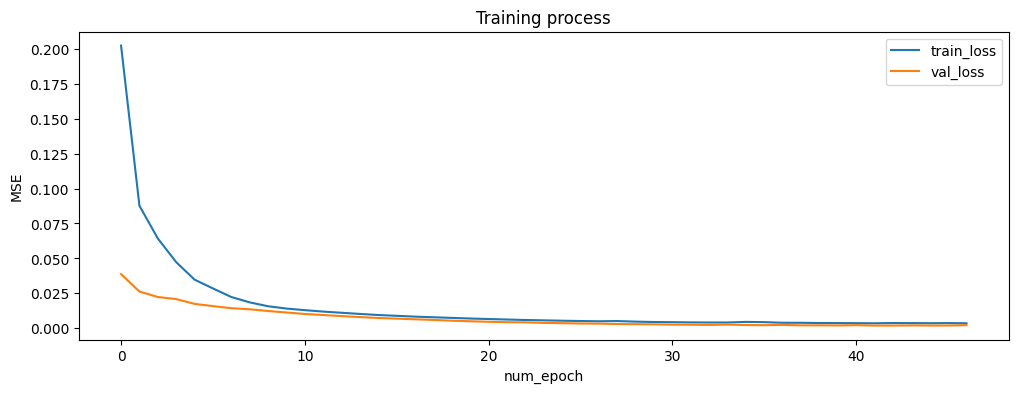

In [25]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history_resid.history['loss'], label='train_loss')
plt.plot(history_resid.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [26]:
results = rnn_model.evaluate(test_X_resid, test_y_resid)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0338
Test Loss: 0.0015214813174679875
Test RMSE: 0.03380439057946205


In [27]:
# คำนวณ predicted residuals
yhat_train_resid = rnn_model.predict(train_X_resid)
yhat_val_resid = rnn_model.predict(val_X_resid)
yhat_test_resid = rnn_model.predict(test_X_resid)

6/6 [==============================] - 0s 2ms/step


In [28]:
# Final predicted value = LSTM predicted value + GRU predicted residuals
final_yhat_train = yhat_train + yhat_train_resid
final_yhat_val = yhat_val + yhat_val_resid
final_yhat_test = yhat_test + yhat_test_resid


In [29]:
# Reshape ข้อมูล (ถ้าจำเป็น)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Rescale ข้อมูลกลับ (ในกรณีใช้ Min-Max Normalization)
inv_yhat_train = final_yhat_train * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_val = final_yhat_val * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_test = final_yhat_test * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']

inv_y_train = train_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_val = val_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_test = test_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']


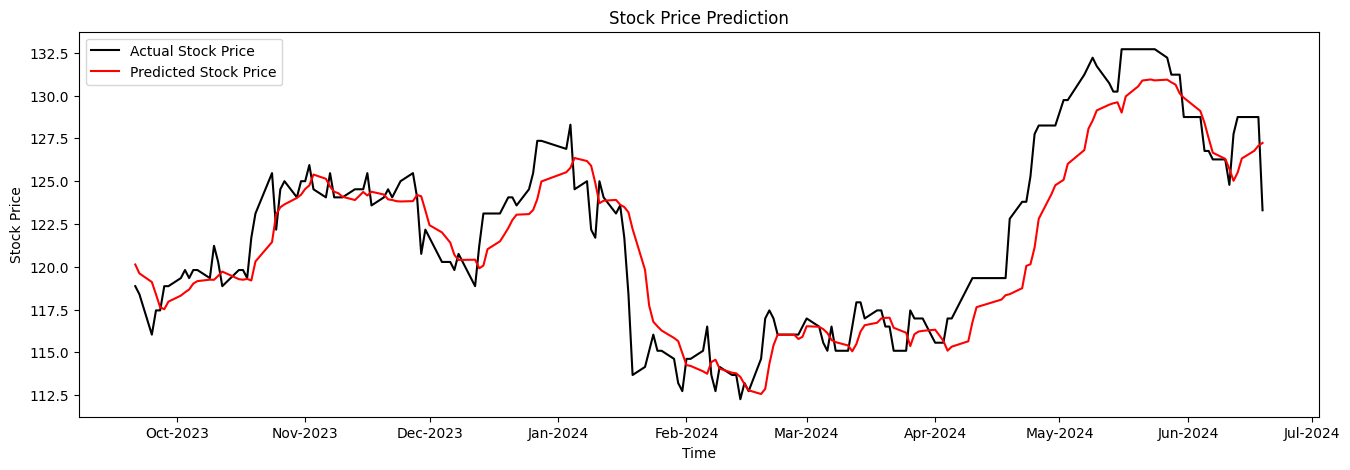

In [30]:
# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(16, 5))
plt.plot(date_test, inv_y_test[:, 0], color='black', label='Actual Stock Price')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='Predicted Stock Price')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 3 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# ตั้งชื่อกราฟ
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

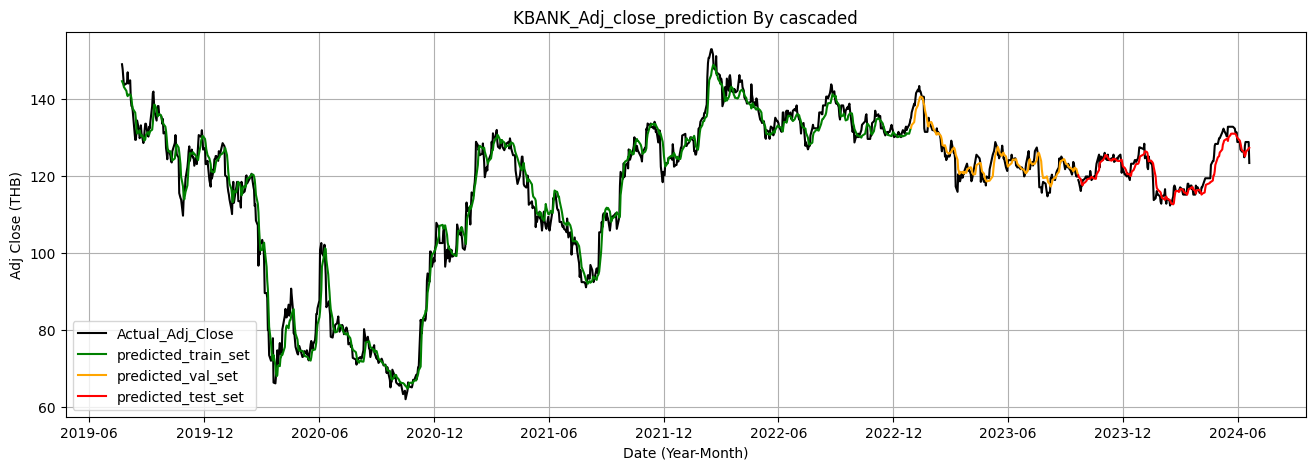

In [31]:
# Visualizing Results
plt.figure(figsize=(16, 5))

# Actual prices
plt.plot(date_train, inv_y_train[:, 0], color='black', label='Actual_Adj_Close')
plt.plot(date_val, inv_y_val[:, 0], color='black')
plt.plot(date_test, inv_y_test[:, 0], color='black')

# Predicted prices
plt.plot(date_train, inv_yhat_train[:, 0], color='green', label='predicted_train_set')
plt.plot(date_val, inv_yhat_val[:, 0], color='orange', label='predicted_val_set')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='predicted_test_set')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 6 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# ตั้งชื่อกราฟ
plt.title('KBANK_Adj_close_prediction By cascaded')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Adj Close (THB)')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# คำนวณ MAPE และ RMSE
mape = mean_absolute_percentage_error(inv_y_test, inv_yhat_test)*100
rmse = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))

# แสดงผลลัพธ์
print(f'MAPE: {mape:.4f}%')
print(f'RMSE: {rmse:.4f}')


MAPE: 1.9720%
RMSE: 3.2347
